In [32]:
import pymongo
from pymongo import ReturnDocument
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

client = pymongo.MongoClient("localhost", 27017)
db = client.outfitPlanner

dataMapper = lambda outfit: {
    "temp": outfit["weather"]["temp"],
    "worn_times": getWornTimes(outfit),
    "clouds": outfit["weather"]["clouds"],
    "humidity": outfit["weather"]["humidity"],
    "pressure": outfit["weather"]["pressure"],
    "wind_speed": outfit["weather"]["wind_speed"]
}

In [78]:
def scale_features(X):
    X[:, 0] *= 5
    X[:, 1] *= 2
    return X

In [83]:
outfits = list(db.worns.find({}))
data = [dataMapper(outfit) for outfit in outfits ]
y_data = pd.DataFrame(outfits)
Y = y_data.loc[:, y_data.columns == "outfitId"]

df = pd.DataFrame(data)
X = df.loc[:, df.columns != 'outfitId']
#scaler = preprocessing.StandardScaler().fit(X)
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

#scale temp and worn_times
X_scaled = scale_features(X_scaled)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_scaled, Y)

newOutfit = dict({
    "weather": dict({
        "clouds": 3,
        "humidity": 82,
        "pressure": 1004,
        "temp": 22,
        "wind_speed": 4.32
    })
})
newOutfitWeighted = dataMapper(newOutfit)

newCase = [newOutfitWeighted]
newCaseDf = pd.DataFrame(newCase)
scaled = scaler.transform(newCaseDf[0:1])
scaled = scale_features(scaled)

pred_proba = neigh.predict_proba(scaled)
pred_proba = pred_proba[0]

zipped = zip(neigh.classes_, pred_proba)
sortedOutfits = sorted(zipped, key = lambda t: t[1])
print("Sorted outfits: ", sortedOutfits)

wornIds = [int(x[0]) for x in sortedOutfits]
res = np.array([list(db.outfits.find({"id": x})) for x in wornIds]).flatten()
outfitsNeverWorn = np.array(list(db.outfits.find({"id": {"$nin": wornIds}})))

Sorted outfits:  [(36, 0.0), (38, 0.0), (37, 1.0)]


c:\users\adam\projekty\outfit-planner\flask-server\op\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


In [60]:
df

,temp,worn_times,clouds,humidity,pressure,wind_speed
0,12.72,3,3,82,1004,4.32
1,18.72,3,3,82,1004,4.32
2,2.72,3,3,82,1004,4.32
3,-2.72,3,3,82,1004,4.32
4,5.72,3,3,82,1004,4.32
5,17.72,3,3,82,1004,4.32
6,15.02,3,3,82,1004,4.32
7,10.72,3,3,82,1004,4.32
8,11.72,3,3,82,1004,4.32


In [63]:
Y

,outfitId
0,36
1,37
2,38
3,38
4,38
5,37
6,37
7,36
8,36


In [64]:
print(X_scaled)

[[3.60074627 0.         0.         0.         0.         0.        ]
 [5.         0.         0.         0.         0.         0.        ]
 [1.26865672 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [1.96828358 0.         0.         0.         0.         0.        ]
 [4.76679104 0.         0.         0.         0.         0.        ]
 [4.13712687 0.         0.         0.         0.         0.        ]
 [3.13432836 0.         0.         0.         0.         0.        ]
 [3.36753731 0.         0.         0.         0.         0.        ]]


In [65]:
print(scaled[0])

[ 1.15298507 -2.          0.          0.          0.          0.        ]


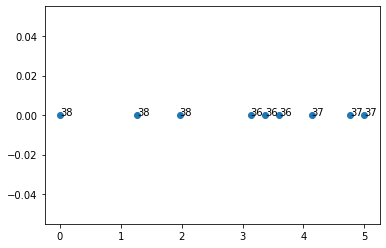

In [67]:
fig, ax = plt.subplots()

x = X_scaled[:,0]
y = X_scaled[:,1]
#pred = neigh.predict(np.array(X_scaled))
ax.scatter(x, y)

for i in range(len(x)):
    ax.annotate(Y.iloc[i]["outfitId"], (x[i], y[i]))